Вихідні дані

Тестовий пакет – MIRFlickr-20k (https://press.liacs.nl/mirflickr/#sec_download)
Вибірка зображень – 250 зображень;
Формування вибірки зображень – псевдовипадкове, з використанням генератора Мерсена (стартове значення співпадає з номером студента в загальному списку групи) за модулем кількості зображень в тестовому пакеті.

Лабораторна робота №1
1)	Сформувати тестову вибірку зображень з вихідного пакету;


In [1]:
import numpy as np
import pandas as pd

import os
import cv2
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


os.chdir('C:\\DS\\datasets\\mirflickr')# all datasets will be stored outside of a project
total_students = 10
student_num = 3%total_students

To select a sample we'll use numpy.random module, an implementation of Mersenne Twister pseudorandom generator based on [MT19937 algorithm](https://en.wikipedia.org/wiki/Mersenne_Twister). It's worth mentioning that python's random module is identical

In [2]:
contents = os.listdir()
images_names = np.array([c for c in contents if c.endswith('.jpg')])

# np.seed(student_num)
generator = np.random.RandomState(seed=student_num)# works the same as np.seed()

total_images = images_names.shape[0]
sample_size = 250

sample_images_names = generator.choice(images_names,sample_size) 

print(f'selected sample {sample_size} of images from {total_images} images in total')

selected sample 250 of images from 25000 images in total


To read the images we'll use opencv, which by default reads image in B,G,R order. 
* cv.imread(file) reads image as an ndarray of shape (height,width,3)
* cv.split() split ndarray into three 2D arrays (B,G,R) of shape (height,width), from which we select array G

In [3]:
#sample_images = np.array([cv2.imread(img) for img in sample_images_names])
sample_images_green = np.array([cv2.split(cv2.imread(img))[1] for img in sample_images_names])

In [4]:
green_pixels_list = np.concatenate([img.flatten() for img in sample_images_green])
green_pixels_value_counts = np.bincount(green_pixels_list)
brightness_distribution = pd.Series(data = green_pixels_value_counts, index=np.arange(256),name='name')

2)	Для зеленого каналу кольору тестових зображень обчислити наступні характеристики розподілу значень яскравості пікселів:<br>
* 	Математичне очікування та дисперсію:

In [5]:
from statsmodels.stats.weightstats import DescrStatsW
weightstats = DescrStatsW(brightness_distribution.keys(),weights=brightness_distribution.values)

In [6]:
avg = np.average(brightness_distribution.keys(),weights=brightness_distribution.values)
assert avg==green_pixels_list.mean()
np.testing.assert_almost_equal(np.average((brightness_distribution.keys()-avg)**2,weights=brightness_distribution.values),np.var(green_pixels_list))

In [7]:
mean, variance = weightstats.mean, weightstats.var
print(f'green channel has a mean of {mean:.4f} and a variance of {variance:.4f}')

green channel has a mean of 100.9230 and a variance of 5702.3071


* 	Медіану та інтерквартильний розмах;

In [8]:
median,iqr = np.median(green_pixels_list), np.subtract(*np.percentile(green_pixels_list,[75,25]))
print(f'green channel has a median of {median} and an IQR of {iqr}')

green channel has a median of 90.0 and an IQR of 127.0


* 	Коефіцієнти асиметрії та ексцесу (нормалізований);

In [9]:
skewness,kurtosis = stats.skew(green_pixels_list),stats.kurtosis(green_pixels_list)
print(f'green channel has a skew of {skewness:.4f} and kurtosis coeff of {kurtosis:.4f}')

green channel has a skew of 0.3841 and kurtosis coeff of -0.9989


* 	Гістограму значень яскравості пікселів (нормалізовану);

3)	Провести обробку отриманих гістограм: 
*	Провести апроксимацію гістограм з використанням імовірнісних розподілів:
 *      i)	Нормального (гаусового) розподілу;
 *      ii)	Розподілу Лапласа;
 *      iii)	Розподілу Стьюдента;
 *      iv)	Бета розподілу;


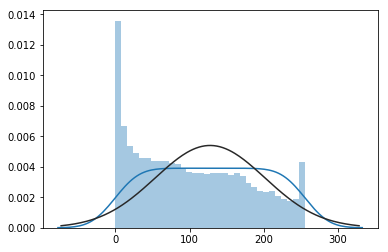

In [10]:
sns.distplot(brightness_distribution.keys(), bins=32, hist_kws={'weights':brightness_distribution.values},norm_hist=True,fit=stats.norm) 

Should it be like that?

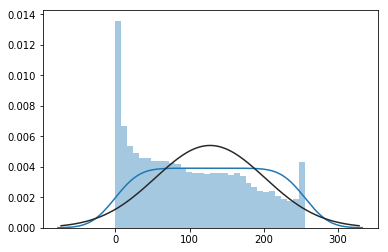

In [11]:
sns.distplot(brightness_distribution.keys(), bins=32, hist_kws={'weights':brightness_distribution.values},norm_hist=True,fit=stats.t) 

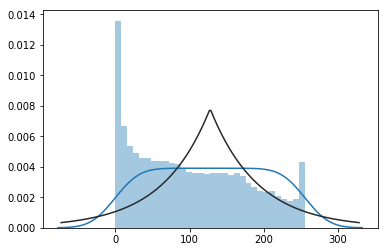

In [12]:
sns.distplot(brightness_distribution.keys(), bins=32, hist_kws={'weights':brightness_distribution.values},fit=stats.laplace) 

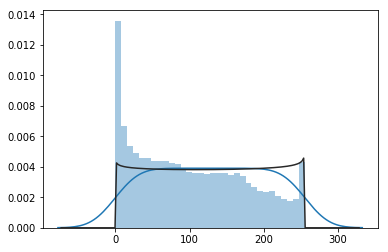

In [13]:
sns.distplot(brightness_distribution.keys(), bins=32, hist_kws={'weights':brightness_distribution.values},fit=stats.beta) 

* 	Для кожної гістограми визначити найкращий тип апроксимуючого розподілу за критерієм мінімізації середньо квадратичного відхилення;

In [14]:
def calculate_mse(distribution='norm'):
    space = np.linspace(0,255,num=256)
    if distribution=='norm':
        pdf = stats.norm.pdf(space,*stats.norm.fit(brightness_distribution.values))#wrong fit
    elif distribution == "t":
        pdf = stats.t.pdf(space,*stats.t.fit(brightness_distribution.values))
    elif distribution =='laplace':
        pdf = stats.laplace.pdf(space,*stats.laplace.fit(brightness_distribution.values))
    elif distribution == 'beta':
        pdf = stats.beta.pdf(space,*stats.beta.fit(brightness_distribution.values))
        
    predicted = pdf * brightness_distribution.values.sum()
    return mean_squared_error(brightness_distribution.values,predicted), predicted

In [15]:
calculate_mse('norm')[0]

48407716530.02425

In [16]:
calculate_mse('t')[0]

48400143509.868004

In [17]:
calculate_mse('laplace')[0]

48420104450.147156

In [18]:
calculate_mse('beta')[0]

c:\users\alexa\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_continuous_distns.py:515: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
c:\users\alexa\appdata\local\programs\python\python37\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


48427296272.17969

*	Побудувати розподіл отриманих апроксимацій за видом апроксимуючого розподілу;

4)	Побудувати багатовимірні гаусові моделі:
*	Сформувати вектори параметрів розподілу значень яскравості пікселів тестових зображень;
    *   i)	Математичне очікування;
    *   ii)	Математичне очікування та дисперсія;
    *   iii)	Математичне очікування, дисперсія та коефіцієнт асиметрії;
    *    iv)	Математичне очікування, дисперсія, коефіцієнти асиметрії та ексцесу;


*	Визначити параметри багатовимірних гаусових моделей для кожної групи векторів, відобразити їх графічно та у вигляді таблиць.

*   Підготувати звіт за отриманими результатами лабораторної роботи.